# Predicting Wildfire Risk in California
## Team Members:

Josh Hong - johong@csumb.edu

Jamal Ahmed - jaahmed@csumb.edu

Krishna Tagdiwala - ktagdiwala@csumb.edu

James Mondragon - jaimondragon@csumb.edu



## Introduction
Our project aims to build a machine learning tool to predict the likelihood and severity of wildfires in California based on environmental and temporal factors.
We are using historical wildfire and drought data to predict:

* A wildfire risk score (1-10 scale) for a given California city, zip code, or area.

* A binary classification to indicate whether a wildfire, if it occurs, is likely to be "large" (burns over 100 acres).

* A rough time estimate (in days) of how long it will take to contain a particular wildfire

While we plan to explore all tasks, we are currently prioritizing the classification model as recommended



## Dataset Description
We are currently using three main datasets:

* [1.88 Million US Wildfires (1992-2015)](https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires)
Source: U.S. federal, state, and local fire organizations
Fields include: fire size, discovery date, location, cause, and fire type.

* [USA + California Wildfire Dataset (2000-2022)](https://www.kaggle.com/datasets/avkashchauhan/california-wildfire-dataset-from-2000-2021)
Contains spatial and temporal wildfire occurrences.

* [Drought and Weather Dataset](https://www.kaggle.com/datasets/cdminix/us-drought-meteorological-data) Includes: drought severity, soil data, precipitation, temperature, wind speed.



# Predictor Features
Features we plan to use

### From the 1.88 Million US Wildfires dataset:
* DISCOVERY_DATE (converted to month and day of year)
* CONT_DATE (converted to month and day of year)
* LATITUDE, LONGITUDE
* STAT_CAUSE_DESCR (fire cause)
* FIRE_SIZE
* FIRE_SIZE_CLASS

### From the MODIS/VIIRS dataset:
* confidence (fire detection confidence score)
* instrument (MODIS or VIIRS)
* month, year
* latitude, longitude

### From the Drought and Soil dataset:
* elevation
* slope1 to slope6 (percent area in different slope categories)
* lat, lon or fips for location matching

#Preprocessing

In [138]:
#Code for pre processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
from google.colab import files
#ML Libaries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error

Load and process datasets

In [139]:
# # Upload the Kaggle API key from your Kaggle account
# files.upload()

# # Move kaggle.json to the correct location and secure it
# os.makedirs('/root/.kaggle', exist_ok=True)
# !mv kaggle.json /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

# Load the dataset for USA+California Wildfire Data (2000 - 03/25/2022)
file_path = "ca_daily_fire_2000_03252022.csv"

df_fires_CA = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "avkashchauhan/california-wildfire-dataset-from-2000-2021",
    file_path,
)

# Load selected columns from the 1.88 Million US Wildfires SQLite dataset
sqlite_file = "FPA_FOD_20170508.sqlite"

query = """
SELECT DISCOVERY_DATE, CONT_DATE, LATITUDE, LONGITUDE, STAT_CAUSE_DESCR, FIRE_SIZE, FIRE_SIZE_CLASS
FROM Fires
"""

df_fires_US = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rtatman/188-million-us-wildfires",
    sqlite_file,
    sql_query=query
)

# Convert Julian date to datetime format
df_fires_US['DISCOVERY_DATE'] = pd.to_datetime(df_fires_US['DISCOVERY_DATE'], origin='julian', unit='D')
df_fires_US['CONT_DATE'] = pd.to_datetime(df_fires_US['CONT_DATE'], origin='julian', unit='D')
df_fires_US['MONTH'] = df_fires_US['DISCOVERY_DATE'].dt.month

# Load the dataset for Predict Droughts using Weather & Soil Data
file_path = "soil_data.csv"

df_drought = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "cdminix/us-drought-meteorological-data",
    file_path,
)

cols = ['fips', 'lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6']
df_drought = df_drought[cols]

<ipython-input-139-661124611>:12: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_fires_CA = kagglehub.load_dataset(
<ipython-input-139-661124611>:26: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_fires_US = kagglehub.load_dataset(
<ipython-input-139-661124611>:41: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_drought = kagglehub.load_dataset(


In [140]:
print(df_fires_US.isnull().sum())

DISCOVERY_DATE           0
CONT_DATE           891531
LATITUDE                 0
LONGITUDE                0
STAT_CAUSE_DESCR         0
FIRE_SIZE                0
FIRE_SIZE_CLASS          0
MONTH                    0
dtype: int64


#Exploration & Visualization

In [141]:
df_fires_CA.head()

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month
0,32.35,-114.77,2022-03-23,Aqua,MODIS,80,2022,3
1,32.36,-114.76,2022-03-24,N,VIIRS,50,2022,3
2,32.36,-114.77,2022-03-24,N,VIIRS,50,2022,3
3,32.36,-114.76,2022-03-23,N,VIIRS,50,2022,3
4,32.36,-114.76,2022-03-23,N,VIIRS,50,2022,3


In [142]:
df_fires_CA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116861 entries, 0 to 1116860
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   latitude    1116861 non-null  float64
 1   longitude   1116861 non-null  float64
 2   acq_date    1116861 non-null  object 
 3   satellite   1116861 non-null  object 
 4   instrument  1116861 non-null  object 
 5   confidence  1116861 non-null  int64  
 6   year        1116861 non-null  int64  
 7   month       1116861 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 68.2+ MB


In [143]:
pd.set_option('display.float_format', '{:,.2f}'.format)
df_fires_CA.describe()

,latitude,longitude,confidence,year,month
count,"1,116,861.00","1,116,861.00","1,116,861.00","1,116,861.00","1,116,861.00"
mean,38.60,-120.64,60.10,"2,017.01",7.99
std,2.38,2.23,18.52,4.33,2.01
min,32.35,-124.00,50.00,"2,000.00",1.00
25%,36.89,-122.71,50.00,"2,015.00",8.00
50%,39.15,-121.02,50.00,"2,018.00",8.00
75%,40.53,-119.16,58.00,"2,020.00",9.00
max,42.00,-114.00,100.00,"2,022.00",12.00


In [144]:
df_fires_US.head(500)

,DISCOVERY_DATE,CONT_DATE,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,MONTH
0,2005-02-02,2005-02-02,40.04,-121.01,Miscellaneous,0.10,A,2
1,2004-05-12,2004-05-12,38.93,-120.40,Lightning,0.25,A,5
2,2004-05-31,2004-05-31,38.98,-120.74,Debris Burning,0.10,A,5
3,2004-06-28,2004-07-03,38.56,-119.91,Lightning,0.10,A,6
4,2004-06-28,2004-07-03,38.56,-119.93,Lightning,0.10,A,6
...,...,...,...,...,...,...,...,...
495,2005-06-10,2005-06-10,35.74,-105.88,Lightning,0.10,A,6
496,2005-07-24,2005-07-24,43.59,-103.62,Lightning,1.00,B,7
497,2005-06-21,2005-06-22,35.67,-105.83,Lightning,0.10,A,6
498,2005-07-25,2005-07-26,44.08,-107.30,Lightning,1.00,B,7


In [145]:
df_fires_US.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   DISCOVERY_DATE    datetime64[ns]
 1   CONT_DATE         datetime64[ns]
 2   LATITUDE          float64       
 3   LONGITUDE         float64       
 4   STAT_CAUSE_DESCR  object        
 5   FIRE_SIZE         float64       
 6   FIRE_SIZE_CLASS   object        
 7   MONTH             int32         
dtypes: datetime64[ns](2), float64(3), int32(1), object(2)
memory usage: 107.6+ MB


In [146]:
df_fires_US.describe()

,DISCOVERY_DATE,CONT_DATE,LATITUDE,LONGITUDE,FIRE_SIZE,MONTH
count,1880465,988934,"1,880,465.00","1,880,465.00","1,880,465.00","1,880,465.00"
mean,2004-02-28 03:46:07.143020416,2004-08-20 06:04:44.859454848,36.78,-95.70,74.52,5.93
min,1992-01-01 00:00:00,1992-01-01 00:00:00,17.94,-178.80,0.00,1.00
25%,1998-09-28 00:00:00,1997-09-09 06:00:00,32.82,-110.36,0.10,3.00
50%,2004-06-21 00:00:00,2005-04-06 00:00:00,35.45,-92.04,1.00,6.00
75%,2009-07-23 00:00:00,2011-07-11 00:00:00,40.83,-82.30,3.30,8.00
max,2015-12-31 00:00:00,2016-01-04 00:00:00,70.33,-65.26,"606,945.00",12.00
std,NaN,NaN,6.14,16.72,"2,497.60",2.95


In [147]:
df_drought.head()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6
0,1001,32.54,-86.64,63,0.04,0.28,0.30,0.25,0.11,0.02
1,1005,31.87,-85.41,146,0.02,0.19,0.54,0.24,0.01,0.00
2,1003,30.66,-87.75,52,0.07,0.44,0.44,0.05,0.00,0.00
3,1007,33.02,-87.13,93,0.01,0.16,0.37,0.35,0.09,0.01
4,1009,33.98,-86.57,198,0.01,0.09,0.28,0.36,0.15,0.10


In [148]:
df_drought.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fips       3109 non-null   int64  
 1   lat        3109 non-null   float64
 2   lon        3109 non-null   float64
 3   elevation  3109 non-null   int64  
 4   slope1     3109 non-null   float64
 5   slope2     3109 non-null   float64
 6   slope3     3109 non-null   float64
 7   slope4     3109 non-null   float64
 8   slope5     3109 non-null   float64
 9   slope6     3109 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 243.0 KB


In [149]:
df_drought.describe()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6
count,"3,109.00","3,109.00","3,109.00","3,109.00","3,109.00","3,109.00","3,109.00","3,109.00","3,109.00","3,109.00"
mean,"30,678.54",38.28,-91.66,427.62,0.05,0.30,0.32,0.16,0.05,0.07
std,"14,986.02",4.84,11.49,500.16,0.09,0.22,0.17,0.13,0.07,0.13
min,"1,001.00",25.60,-124.21,-1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"19,045.00",34.69,-98.05,132.00,0.01,0.11,0.19,0.04,0.00,0.00
50%,"29,213.00",38.33,-90.18,272.00,0.03,0.27,0.35,0.13,0.01,0.00
75%,"46,009.00",41.70,-83.37,483.00,0.07,0.48,0.46,0.26,0.09,0.05
max,"56,045.00",48.84,-67.61,"3,561.00",0.97,0.76,0.70,0.57,0.33,0.61


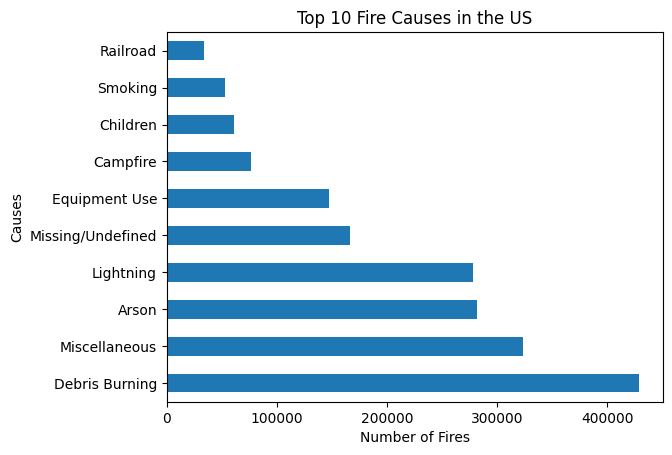

In [150]:
# Top 10 fire causes in US
df_fires_US['STAT_CAUSE_DESCR'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Fire Causes in the US')
plt.xlabel('Number of Fires')
plt.ylabel('Causes')
plt.show()

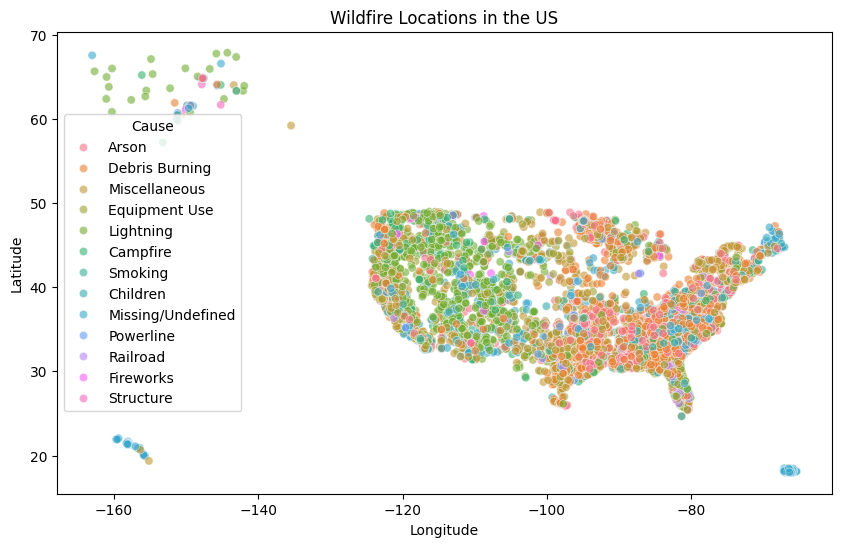

In [151]:
# Wildfire Locations on a Map (US)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_fires_US.sample(10000), x='LONGITUDE', y='LATITUDE', hue='STAT_CAUSE_DESCR', alpha=0.6, legend=True)
plt.title("Wildfire Locations in the US")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Cause')
plt.show()

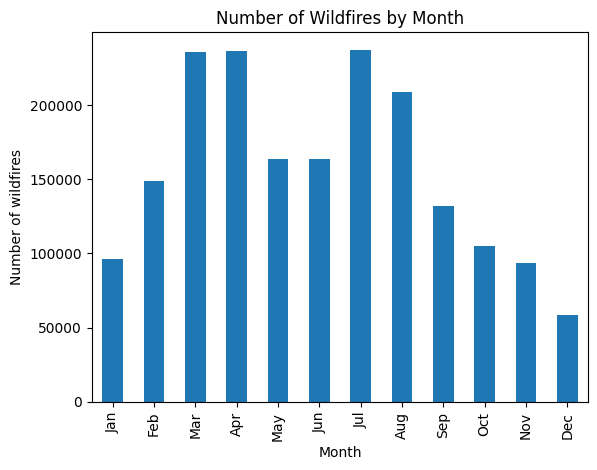

In [152]:
# Wildfires by Month in US
df_fires_US['Month'] = df_fires_US['DISCOVERY_DATE'].dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df_fires_US['Month'].value_counts().sort_index().plot(kind='bar')
plt.xticks(ticks=range(0,12), labels=month_names)

plt.title('Number of Wildfires by Month')
plt.xlabel('Month')
plt.ylabel('Number of wildfires')
plt.show()

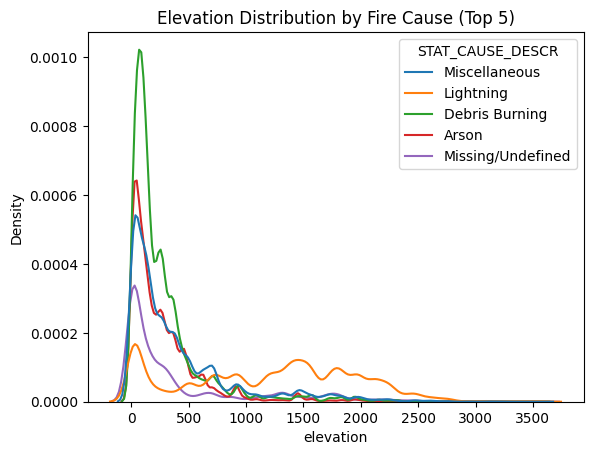

In [153]:
# Elevation Distribution by Fire Cause (Top 5)

# Join fire and drought data by closest lat/lon
drought_coords = df_drought[['lat', 'lon']].values
fire_coords = df_fires_US[['LATITUDE', 'LONGITUDE']].dropna().values

# Fit nearest neighbor model
nn = NearestNeighbors(n_neighbors=1)
nn.fit(drought_coords)

# Get indices of nearest drought point for each fire
distances, indices = nn.kneighbors(fire_coords)

# Join datasets
matched_drought = df_drought.iloc[indices.flatten()].reset_index(drop=True)
fires_with_drought = df_fires_US.iloc[:len(matched_drought)].reset_index(drop=True)
fires_with_drought = pd.concat([fires_with_drought, matched_drought], axis=1)

# Subset df with top 5 causes
top_causes = fires_with_drought['STAT_CAUSE_DESCR'].value_counts().nlargest(5).index
subset = fires_with_drought[fires_with_drought['STAT_CAUSE_DESCR'].isin(top_causes)]

# Plot KDE
top_causes = fires_with_drought['STAT_CAUSE_DESCR'].value_counts().nlargest(5).index
subset = fires_with_drought[fires_with_drought['STAT_CAUSE_DESCR'].isin(top_causes)]

sns.kdeplot(data=subset, x='elevation', hue='STAT_CAUSE_DESCR', fill=False, alpha=1)
plt.title("Elevation Distribution by Fire Cause (Top 5)")
plt.show()


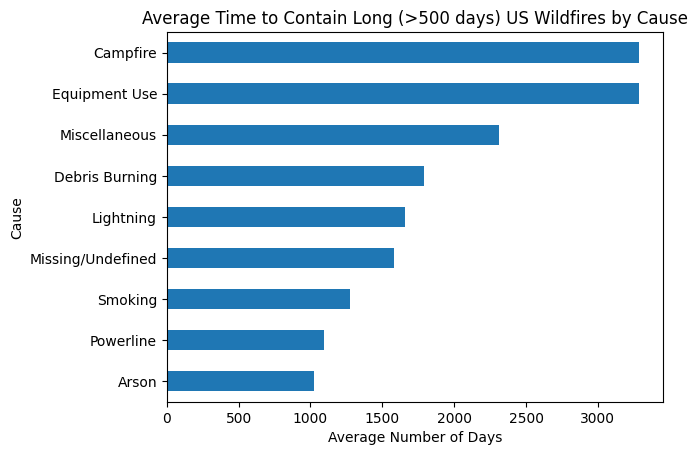

In [154]:
# Avg days to contain long wildfires by cause in US
df_fires_US['cont_days'] = (pd.to_datetime(df_fires_US['CONT_DATE']) - pd.to_datetime(df_fires_US['DISCOVERY_DATE'])).dt.days

df_fires_US[df_fires_US['cont_days']>500].groupby('STAT_CAUSE_DESCR')['cont_days'].mean().sort_values(ascending=True).plot(kind='barh')

plt.title('Average Time to Contain Long (>500 days) US Wildfires by Cause')
plt.xlabel('Average Number of Days')
plt.ylabel('Cause')
plt.show()

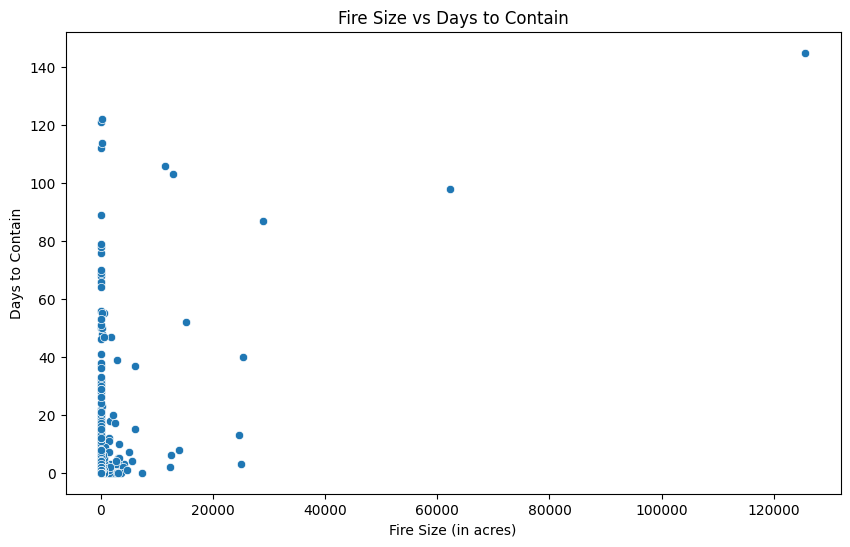

In [155]:
# Fire size vs days to contain
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_fires_US.sample(10000), x='FIRE_SIZE', y='cont_days')
plt.title("Fire Size vs Days to Contain")
plt.xlabel("Fire Size (in acres)")
plt.ylabel("Days to Contain")
plt.show()

# Preliminary work on Machine Learning

In [137]:
#test/train dataset split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Create target variable
df_fires_US['Large_Fire'] = (df_fires_US['FIRE_SIZE'] > 100).astype(int)

# Select features and target
features = ['LATITUDE', 'LONGITUDE', 'MONTH']
X = df_fires_US[features]
y = df_fires_US['Large_Fire']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 